In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

In [29]:
# Load dataset
df_combine = pd.read_csv('transaction_dataset.csv')
print('raw shape:', df_combine.shape)
display(df_combine.head())
f_txn = len(df_combine[df_combine['FLAG'] == 1])
print('current number of frauds:', f_txn, ' which is ', (f_txn/len(df_combine))*100, ' % of the original dataset')

raw shape: (9841, 51)


,Unnamed: 0,Index,Address,FLAG,Avg min between sent tnx,Avg min between received tnx,Time Diff between first and last (Mins),Sent tnx,Received Tnx,Number of Created Contracts,...,ERC20 min val sent,ERC20 max val sent,ERC20 avg val sent,ERC20 min val sent contract,ERC20 max val sent contract,ERC20 avg val sent contract,ERC20 uniq sent token name,ERC20 uniq rec token name,ERC20 most sent token type,ERC20_most_rec_token_type
0,0,1,0x00009277775ac7d0d59eaad8fee3d10ac6c805e8,0,844.26,1093.71,704785.63,721,89,0,...,0.000000,1.683100e+07,271779.920000,0.0,0.0,0.0,39.0,57.0,Cofoundit,Numeraire
1,1,2,0x0002b44ddb1476db43c868bd494422ee4c136fed,0,12709.07,2958.44,1218216.73,94,8,0,...,2.260809,2.260809e+00,2.260809,0.0,0.0,0.0,1.0,7.0,Livepeer Token,Livepeer Token
2,2,3,0x0002bda54cb772d040f779e88eb453cac0daa244,0,246194.54,2434.02,516729.30,2,10,0,...,0.000000,0.000000e+00,0.000000,0.0,0.0,0.0,0.0,8.0,NaN,XENON
3,3,4,0x00038e6ba2fd5c09aedb96697c8d7b8fa6632e5e,0,10219.60,15785.09,397555.90,25,9,0,...,100.000000,9.029231e+03,3804.076893,0.0,0.0,0.0,1.0,11.0,Raiden,XENON
4,4,5,0x00062d1dd1afb6fb02540ddad9cdebfe568e0d89,0,36.61,10707.77,382472.42,4598,20,1,...,0.000000,4.500000e+04,13726.659220,0.0,0.0,0.0,6.0,27.0,StatusNetwork,EOS


current number of frauds: 2179  which is  22.14205873386851  % of the original dataset


In [30]:
# Basic cleaning: drop exact-NA rows and reset index
df_combine = df_combine.dropna().reset_index(drop=True)
print('after dropna shape:', df_combine.shape)

after dropna shape: (7121, 51)


In [31]:
# Check unique counts and dtypes
display(df_combine.nunique())
display(df_combine.dtypes.value_counts())

Unnamed: 0                                              7121
Index                                                   4191
Address                                                 7104
FLAG                                                       2
Avg min between sent tnx                                4054
Avg min between received tnx                            4058
Time Diff between first and last (Mins)                 5629
Sent tnx                                                 493
Received Tnx                                             468
Number of Created Contracts                               17
Unique Received From Addresses                           196
Unique Sent To Addresses                                 222
min value received                                      3829
max value received                                      4540
avg val received                                        4586
min val sent                                            3851
max val sent            

float64    39
int64       9
object      3
Name: count, dtype: int64

In [32]:
# Drop obvious low-variance / useless columns if present
constant_columns = ['Unnamed: 0', 'Index', ' ERC20 uniq sent addr.1', ' ERC20 avg time between rec 2 tnx', ' ERC20 avg time between contract tnx', ' ERC20 min val sent contract', ' ERC20 max val sent contract', ' ERC20 avg val sent contract']
cols_to_drop = [c for c in constant_columns if c in df_combine.columns]
if cols_to_drop:
    df_combine.drop(cols_to_drop, axis=1, inplace=True)
    print('dropped columns:', cols_to_drop)
print('shape after dropping constants:', df_combine.shape)

dropped columns: ['Unnamed: 0', 'Index', ' ERC20 uniq sent addr.1', ' ERC20 avg time between rec 2 tnx', ' ERC20 avg time between contract tnx', ' ERC20 min val sent contract', ' ERC20 max val sent contract', ' ERC20 avg val sent contract']
shape after dropping constants: (7121, 43)


### Notes
Following the paper, we will run Random Forest as a baseline. Added cells below do preprocessing, balancing (SMOTE), a pipeline with scaling, GridSearchCV, evaluation, and saving the model. If `imbalanced-learn` is not installed, run `pip install imbalanced-learn` in your environment.

In [33]:
# Prepare numeric-only DataFrame for Random Forest
print('Selecting numeric columns...')
df_combine_forest = df_combine.select_dtypes(include='number').copy()
print('numeric df shape:', df_combine_forest.shape)
# Ensure target exists
if 'FLAG' not in df_combine_forest.columns:
    raise KeyError('FLAG column not found in numeric dataframe')
print('Dropped non-numeric columns (if any)')

Selecting numeric columns...
numeric df shape: (7121, 40)
Dropped non-numeric columns (if any)


In [34]:
# Features / target split
X = df_combine_forest.drop('FLAG', axis=1)
y = df_combine_forest['FLAG']
print('X shape, y shape:', X.shape, y.shape)
print('Class distribution (counts):')
print(y.value_counts())

X shape, y shape: (7121, 39) (7121,)
Class distribution (counts):
FLAG
0    5771
1    1350
Name: count, dtype: int64


In [35]:
from sklearn.model_selection import train_test_split
# Stratify to preserve class ratio
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=42, stratify=y)
print('Train / test shapes:', X_train.shape, X_test.shape)
print('Train class distribution:')
print(y_train.value_counts())

Train / test shapes: (4984, 39) (2137, 39)
Train class distribution:
FLAG
0    4039
1     945
Name: count, dtype: int64


In [36]:
# Create pipeline: scaler -> SMOTE -> RandomForest inside a single pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
# imbalanced-learn sampler will be used inside pipeline via 'imblearn.pipeline' if available
try:
    from imblearn.over_sampling import SMOTE
    from imblearn.pipeline import Pipeline as ImbPipeline
    sampler_available = True
except Exception as e:
    print('imblearn not available. Install with: pip install imbalanced-learn')
    sampler_available = False
# Define pipeline depending on availability
if sampler_available:
    pipeline = ImbPipeline([('scaler', StandardScaler()), ('smote', SMOTE(random_state=42)), ('rf', RandomForestClassifier(random_state=42, n_jobs=-1))])
else:
    # If SMOTE not available, continue without balancing but keep scaler
    pipeline = Pipeline([('scaler', StandardScaler()), ('rf', RandomForestClassifier(random_state=42, n_jobs=-1))])
print('Pipeline created:', pipeline)

imblearn not available. Install with: pip install imbalanced-learn
Pipeline created: Pipeline(steps=[('scaler', StandardScaler()),
                ('rf', RandomForestClassifier(n_jobs=-1, random_state=42))])


In [37]:
# GridSearch for sensible hyperparameters (kept smaller to run faster)
from sklearn.model_selection import GridSearchCV
params = {
    'rf__n_estimators': [50, 100],
    'rf__max_depth': [None, 10, 20],
    'rf__min_samples_leaf': [1, 5]
}
grid = GridSearchCV(pipeline, param_grid=params, cv=4, scoring='f1', n_jobs=-1, verbose=1)
grid.fit(X_train, y_train)
print('Best CV f1:', grid.best_score_)
print('Best params:', grid.best_params_)
best_pipeline = grid.best_estimator_

Fitting 4 folds for each of 12 candidates, totalling 48 fits
Best CV f1: 0.9676292976953256
Best params: {'rf__max_depth': None, 'rf__min_samples_leaf': 1, 'rf__n_estimators': 100}
Best CV f1: 0.9676292976953256
Best params: {'rf__max_depth': None, 'rf__min_samples_leaf': 1, 'rf__n_estimators': 100}


In [38]:
# Advanced hyperparameter tuning using RandomizedSearchCV (faster over large spaces)
from sklearn.model_selection import RandomizedSearchCV
import random
# Parameter distributions for the RF inside the pipeline (prefix with 'rf__')
param_dist = {
    'rf__n_estimators': [100, 200, 300, 400, 500],
    'rf__max_depth': [None, 5, 10, 15, 20, 30],
    'rf__min_samples_leaf': [1, 2, 4, 6, 8, 10],
    'rf__max_features': ['sqrt', 'log2', 0.2, 0.5],
    'rf__bootstrap': [True, False]
}
# Run randomized search (n_iter kept moderate to limit runtime)
random_search = RandomizedSearchCV(pipeline, param_distributions=param_dist, n_iter=40, cv=4, scoring='f1', n_jobs=-1, verbose=2, random_state=42)
random_search.fit(X_train, y_train)
print('RandomizedSearch best CV f1:', random_search.best_score_)
print('RandomizedSearch best params:')
print(random_search.best_params_)
# Use the best estimator from randomized search as the final pipeline (or refine further)
best_pipeline = random_search.best_estimator_
# Optional: small GridSearch around the best params for fine tuning (uncomment to run)
# from sklearn.model_selection import GridSearchCV
# grid_refine = GridSearchCV(pipeline, param_grid={ 'rf__n_estimators': [random_search.best_params_['rf__n_estimators']], 'rf__max_depth': [random_search.best_params_.get('rf__max_depth')], }, cv=4, scoring='f1', n_jobs=-1, verbose=1)
# grid_refine.fit(X_train, y_train)
# best_pipeline = grid_refine.best_estimator_

Fitting 4 folds for each of 40 candidates, totalling 160 fits
RandomizedSearch best CV f1: 0.9760632576048398
RandomizedSearch best params:
{'rf__n_estimators': 500, 'rf__min_samples_leaf': 2, 'rf__max_features': 0.5, 'rf__max_depth': None, 'rf__bootstrap': False}
RandomizedSearch best CV f1: 0.9760632576048398
RandomizedSearch best params:
{'rf__n_estimators': 500, 'rf__min_samples_leaf': 2, 'rf__max_features': 0.5, 'rf__max_depth': None, 'rf__bootstrap': False}


Classification report:
              precision    recall  f1-score   support

           0     0.9880    1.0000    0.9940      1732
           1     1.0000    0.9481    0.9734       405

    accuracy                         0.9902      2137
   macro avg     0.9940    0.9741    0.9837      2137
weighted avg     0.9903    0.9902    0.9901      2137

Confusion matrix:
[[1732    0]
 [  21  384]]
ROC AUC: 0.9979599692070824


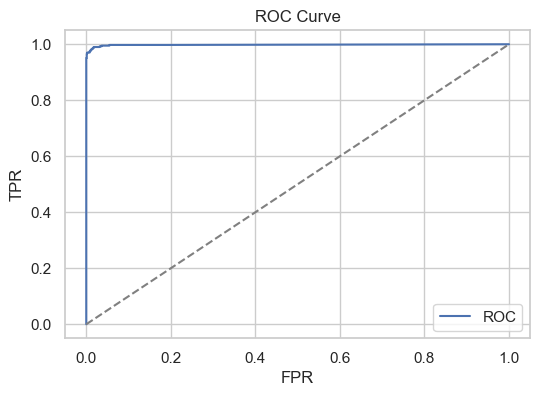

In [39]:
# Evaluate on test set
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_recall_fscore_support
y_pred = best_pipeline.predict(X_test)
print('Classification report:')
print(classification_report(y_test, y_pred, digits=4))
cm = confusion_matrix(y_test, y_pred)
print('Confusion matrix:')
print(cm)
# ROC AUC (for binary labels). Use predict_proba if available
if hasattr(best_pipeline, 'predict_proba'):
    y_prob = best_pipeline.predict_proba(X_test)[:, 1]
    print('ROC AUC:', roc_auc_score(y_test, y_prob))
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    plt.figure(figsize=(6,4))
    plt.plot(fpr, tpr, label='ROC')
    plt.plot([0,1],[0,1],'--',color='gray')
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title('ROC Curve')
    plt.legend()
    plt.show()
else:
    print('predict_proba not available for this pipeline; skipping ROC plot')

,feature,importance
31,ERC20 min val rec,0.248770
26,ERC20 uniq sent addr,0.151249
37,ERC20 uniq sent token name,0.150363
22,Total ERC20 tnxs,0.124812
24,ERC20 total ether sent,0.065513
28,ERC20 uniq rec contract addr,0.042278
38,ERC20 uniq rec token name,0.035828
35,ERC20 max val sent,0.035318
27,ERC20 uniq rec addr,0.032513
36,ERC20 avg val sent,0.021653


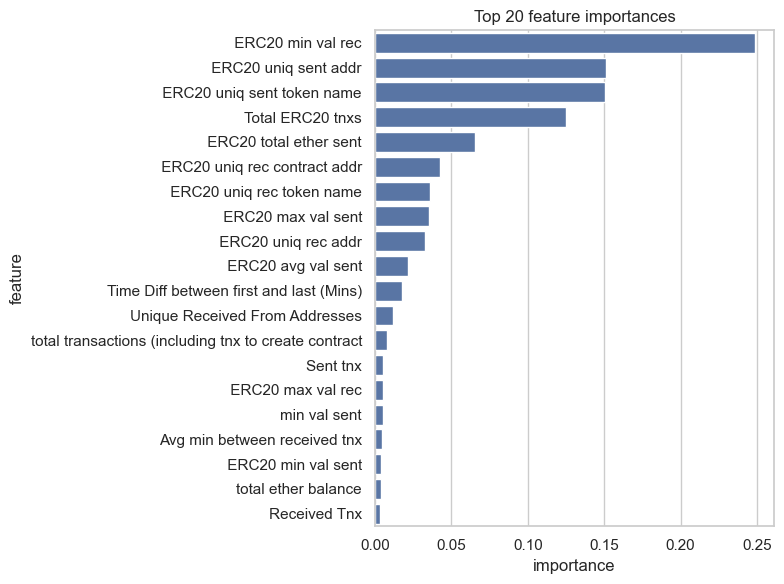

In [40]:
# Extract feature importances from the final RF inside pipeline
# Access rf step depending on pipeline type
try:
    rf_model = best_pipeline.named_steps['rf']
    importances = rf_model.feature_importances_
    feat_df = pd.DataFrame({'feature': X_train.columns, 'importance': importances}).sort_values('importance', ascending=False)
    display(feat_df.head(20))
    plt.figure(figsize=(8,6))
    sns.barplot(x='importance', y='feature', data=feat_df.head(20))
    plt.title('Top 20 feature importances')
    plt.tight_layout()
    plt.show()
except Exception as e:
    print('Could not extract feature importances:', e)

In [41]:
# Save the trained pipeline to disk
import joblib
model_path = 'rf_pipeline.joblib'
joblib.dump(best_pipeline, model_path)
print('Saved pipeline to', model_path)
# Example load: loaded = joblib.load(model_path)

Saved pipeline to rf_pipeline.joblib
